In [59]:
import pandas as pd
import torch as pt
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 

URL = 'https://bit.ly/palmerpenguinscsv'
penguins = pd.read_csv(URL)
penguins.dropna(inplace=True)
penguins.info()
penguins_twovars = penguins[['body_mass_g', 'bill_depth_mm', 'species']]

penguins_twovars_twoclasses =  penguins_twovars[ penguins_twovars['species'] != 'Adelie']


X = pt.Tensor(penguins_twovars_twoclasses[['body_mass_g', 'bill_depth_mm']].values)
y = pt.Tensor((penguins_twovars_twoclasses['species']=='Gentoo').values) 

nRows = X.shape[0]


#train-validation split
ptc_train = .8
pct_valid = .2

pt.manual_seed(1)
shuffled_idx =  pt.randperm(nRows)


#z-score the data

nTrain = int(np.floor(ptc_train*nRows))

X_train = X[shuffled_idx[:nTrain],:]
y_train = y[shuffled_idx[:nTrain]]

X_valid = X[shuffled_idx[nTrain:],:]
y_valid = y[shuffled_idx[nTrain:]]


X_train = (X_train-X_train.mean(axis=0))/X_train.std(axis=0)
X_valid = (X_valid-X_valid.mean(axis=0))/X_valid.std(axis=0)
print(f'{X_train.shape[0]} training examples and {X_valid.shape[0]} validation examples')

<class 'pandas.core.frame.DataFrame'>
Index: 333 entries, 0 to 343
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   rowid              333 non-null    int64  
 1   species            333 non-null    object 
 2   island             333 non-null    object 
 3   bill_length_mm     333 non-null    float64
 4   bill_depth_mm      333 non-null    float64
 5   flipper_length_mm  333 non-null    float64
 6   body_mass_g        333 non-null    float64
 7   sex                333 non-null    object 
 8   year               333 non-null    int64  
dtypes: float64(4), int64(2), object(3)
memory usage: 26.0+ KB
149 training examples and 38 validation examples


In [60]:
class LogisticRegression:
    """
    Logistic regression model from scratch/
    
    -input_size (int): The number of input features (default is 2).
    -seed (int): Seed for reproducibility (default is 1).
    -learning_rate (float): The learning rate for weight updates (default is 0.03).
    -verbose (bool): If True, prints updates during training (default is False)
    """
    
    def __init__(self, input_size=2, seed=1, learning_rate=0.03, mode='step', batch_size =20, verbose=False):
        self.verbose = verbose
        self.learning_rate = learning_rate
        if seed:
            pt.manual_seed(seed)
        self.input_size = input_size
        self.W = pt.randn((1, self.input_size + 1))
        self._max_epochs = 5
        self.batch_size = batch_size
        self.mode = mode
        
    
    def addpadding(self, X):
        """
        Add padding to input data tensor
        """
        left_pad_bool = 1
        right_pad_bool = 0
        pad_value = 1.0
        X_padded = pt.nn.ConstantPad1d((left_pad_bool,right_pad_bool), pad_value)(X)
        
        return X_padded
    
    def activation_function(self, Z):
        """
        Activation function, returns prediction from Z using the specified activation function
        default mode is step
        """
        if self.mode == 'sigmoid':
            output = 1/(1 + pt.exp(-Z))
        elif self.mode == 'step':
            output = pt.where(Z >= 0, pt.tensor(1.0), pt.tensor(-1.0))
        return output
    
    def forwardpass(self, input_data):
        """
        Forward pass of the model, returns prediction from Weigths and input data
        """
        assert input_data.shape[1] == self.W.shape[1] - 1
        X_padded = self.addpadding(input_data)

        Z = X_padded@self.W.t()
        prediction = self.activation_function(Z)
        return prediction
    
    def delta_W(self, inputRow, targetRow):
        """
        Compute weight update for a single row.
        
        """
        probabilities = self.forwardpass(inputRow).squeeze() #receive the probabilities from sigmoid activation function
        
        
        ydiff =  targetRow - probabilities
        
        X_padded = self.addpadding(inputRow)
        

        if pt.abs(ydiff) != 0:
            return self.learning_rate * ydiff * X_padded
        else:
            return None
        
    def predict(self, input_data, threshold=0.5):
        """
        Convert predicted probabilities to class labels.
        """
        probabilities = self.forwardpass(input_data).squeeze()
        return pt.where(probabilities > threshold, 1, 0)
    
    def computeLoss(self, input_data, target_data):
        """
        Compute loss of the model, using binary cross-entropy loss.
        """
        predicted_probabilites = self.forwardpass(input_data).squeeze()
        y_zero_loss = target_data * pt.log(predicted_probabilites)
        y_one_loss = (1 - target_data) * pt.log(1 - predicted_probabilites)
        loss = -pt.mean(y_zero_loss + y_one_loss)
        return loss
   
    
    def _update(self, inputRow, targetRow):
        """
        Update weights based on a single row.
        """
        weight_delta = self.delta_W(inputRow, targetRow)
        if weight_delta != None:
            self.W += weight_delta
            return True
        return False
    
    
    def train(self, X_train, y_train, X_valid, y_valid, max_epochs=None, learning_rate=None):
        """
        Train the model.
        """
        train_loss_path = []
        valid_loss_path = []
        if max_epochs:
            self._max_epochs = max_epochs
        if learning_rate:
            self.learning_rate = learning_rate

        for epoch in range(1, self._max_epochs + 1):
            num_updates = 0
            for idxRow in pt.arange(X_train.shape[0]):
                inputRow = X_train[idxRow: idxRow + 1, :]
                targetRow = y_train[idxRow: idxRow + 1]
                is_update = self._update(inputRow, targetRow)
                if is_update:
                    num_updates += 1
                    if self.verbose:
                        print('u', end='')
                elif self.verbose:
                    print('.', end='')

            print(f'\nEpoch {epoch} complete')
            train_loss = self.computeLoss(X_train, y_train)
            valid_loss = self.computeLoss(X_valid, y_valid)
            train_loss_path.append(valid_loss)
            valid_loss_path.append(valid_loss)
            print(f'train loss: {train_loss}')
            print(f'valid loss: {valid_loss}')
            print(f'train accuracy: {self.accuracy(self.predict(X_train), y_train)}')
            print(f'validation accuracy: {self.accuracy(self.predict(X_valid), y_valid)}')
            print(num_updates)

            if num_updates == 0:
                if self.verbose:
                    print(f'No updates, terminating')
                break

        return train_loss_path, valid_loss_path
    
    def accuracy(self, predicted_data, target_data):
        """
        Calculate accuracy of the model on given data.
        """
        
        return (predicted_data == target_data).sum() / len(target_data)
    


Model without training:
train loss: 0.6071354150772095
valid loss: 0.4953005313873291
train accuracy: 0.5973154306411743
validation accuracy: 0.8157894611358643


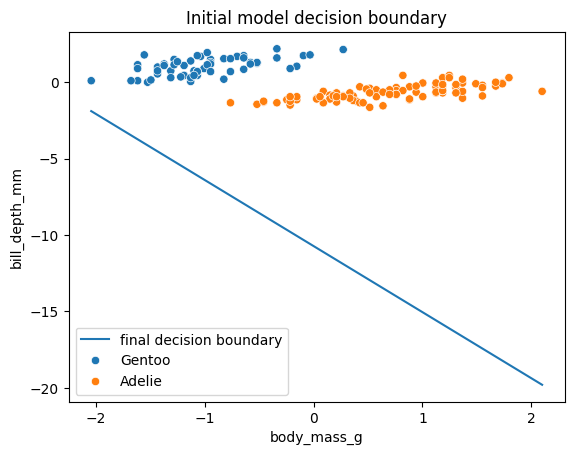

In [61]:
model = LogisticRegression(input_size=2, seed=1, learning_rate=0.01, mode='sigmoid', batch_size=20, verbose=True)
train_loss = model.computeLoss(X_train, y_train)
valid_loss = model.computeLoss(X_valid, y_valid)
print(f'Model without training:')
print(f'train loss: {train_loss}')
print(f'valid loss: {valid_loss}')
print(f'train accuracy: {model.accuracy(model.predict(X_train), y_train)}')
print(f'validation accuracy: {model.accuracy(model.predict(X_valid), y_valid)}')
Weights = model.W 

b = float(- Weights[0,0] / Weights[0,2])
m = float(- Weights[0,1] / Weights[0,2])


xmin, xmax = X_train[:,0].min(), X_train[:,0].max()
xmin, xmax = float(xmin), float(xmax)
plt.subplot()
_ = sns.lineplot(x=[xmin, xmax], y=[m*xmin + b, m*xmax + b], label='final decision boundary')
_ = sns.scatterplot(x=X_train[:,0], y=X_train[:,1], hue=np.array(['Gentoo', 'Adelie'])[(y_train == 1)*1])
_ = plt.xlabel('body_mass_g')
_ = plt.ylabel('bill_depth_mm')
_ = plt.title('Initial model decision boundary')


In [62]:
#train the model
loss_training, loss_validation = model.train(X_train, y_train, X_valid, y_valid, max_epochs=6, learning_rate=0.01)

uuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu
Epoch 1 complete
train loss: 0.337369829416275
valid loss: 0.3046339750289917
train accuracy: 0.9865771532058716
validation accuracy: 1.0
149
uuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu
Epoch 2 complete
train loss: 0.22750160098075867
valid loss: 0.23308949172496796
train accuracy: 1.0
validation accuracy: 1.0
149
uuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu
Epoch 3 complete
train loss: 0.17173036932945251
valid loss: 0.19624033570289612
train accuracy: 1.0
validation accuracy: 1.0
149
uuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuuu

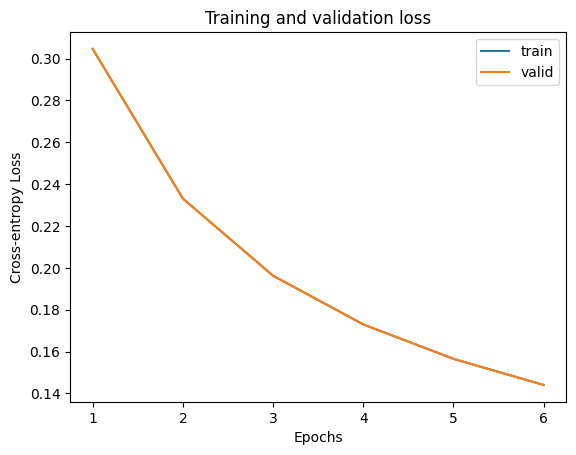

In [63]:
loss_epochs = pd.DataFrame({'Epochs':(np.arange(len(loss_training))+1),
                                   'train loss':loss_training,
                                   'valid loss':loss_validation})

loss_epochs['train loss'] = loss_epochs['train loss'].apply(lambda x: float(x))
loss_epochs['valid loss'] = loss_epochs['valid loss'].apply(lambda x: float(x))
loss_epochs


plt.subplot()
_ = sns.lineplot(data=loss_epochs, x='Epochs', y='train loss', label='train')
_ = sns.lineplot(data=loss_epochs, x='Epochs', y='valid loss', label='valid')
_ = plt.title('Training and validation loss')
_ = plt.xlabel('Epochs')
_ = plt.ylabel('Cross-entropy Loss')




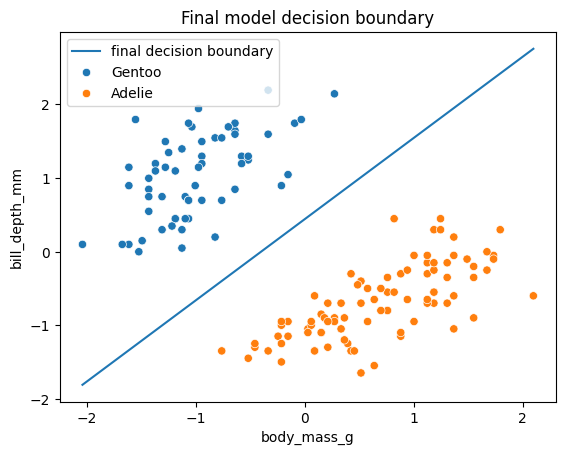

In [64]:
#plot after training
Weights = model.W 

b = float(- Weights[0,0] / Weights[0,2])
m = float(- Weights[0,1] / Weights[0,2])


xmin, xmax = X_train[:,0].min(), X_train[:,0].max()
xmin, xmax = float(xmin), float(xmax)
plt.subplot()
_ = sns.lineplot(x=[xmin, xmax], y=[m*xmin + b, m*xmax + b], label='final decision boundary')
_ = sns.scatterplot(x=X_train[:,0], y=X_train[:,1], hue=np.array(['Gentoo', 'Adelie'])[(y_train == 1)*1])
_ = plt.xlabel('body_mass_g')
_ = plt.ylabel('bill_depth_mm')
_ = plt.title('Final model decision boundary')